<a href="https://colab.research.google.com/github/hublun/Bayesian_Aggregation_Average_Data/blob/master/ODR_2024_1_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [ODE Based Models in Stan](https://mc-stan.org/events/stancon2017-notebooks/stancon2017-margossian-gillespie-ode.html)

#### [Example: simple harmonic oscillator](https://mc-stan.org/docs/stan-users-guide/example-simple-harmonic-oscillator.html#example-simple-harmonic-oscillator)

## [Bayesian workflow for disease transmission modeling in Stan](https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html)

#### [ Ordinary differential equation (ODE) solvers](https://mc-stan.org/docs/functions-reference/functions-ode-solver.html#functions-ode-solver)


In [1]:
install.packages("rstan", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘matrixStats’, ‘StanHeaders’, ‘inline’, ‘gridExtra’, ‘Rcpp’, ‘RcppParallel’, ‘loo’, ‘QuickJSR’, ‘RcppEigen’, ‘BH’




In [1]:
library(rstan)

Loading required package: StanHeaders




rstan version 2.32.5 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




In [2]:
parallel::detectCores()

[1] 8

In [3]:
#example(stan_model, package = "rstan", run.dontrun = TRUE)

In [4]:
#install.packages('tidybayes')

In [5]:
knitr::opts_chunk$set(echo = TRUE)
# color palette
c_light <- c("#fee0d2")
c_mid <- c("#fc9272")
c_dark <- c("#de2d26")
c_simu <- "chartreuse3"
c_posterior = "orange"
c_prior = "aquamarine2"

set.seed(1) # for reproductibility



---



## COVID-19 transmission in Switzerland

#### To illustrate the ideas presented in this tutorial, we are going to tackle a more complex example: COVID-19 transmission in Switzerland during the period from February 2020 to June 2020. We’ll see that in this more complicated setting, sampling from the posterior distribution can be difficult, and we’ll need to rely on Stan’s diagnostics to check that our inference is reliable.

In [6]:
library(tidybayes)
library(tidyverse)
library(gridExtra)
df_swiss <- read_csv("./disease_transmission_workflow/data/swiss_agg_data.csv")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.2.1     ✔ stringr 1.5.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Rows: 132 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (8): onset_dt, test_dt, report_dt, hospit_dt, death_dt, death_dt_hospit...
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
spec(df_swiss)

cols(
  date = col_date(format = ""),
  onset_dt = col_double(),
  test_dt = col_double(),
  report_dt = col_double(),
  hospit_dt = col_double(),
  death_dt = col_double(),
  death_dt_hospit = col_double(),
  death_dt_nohospit = col_double(),
  total_tested = col_double()
)

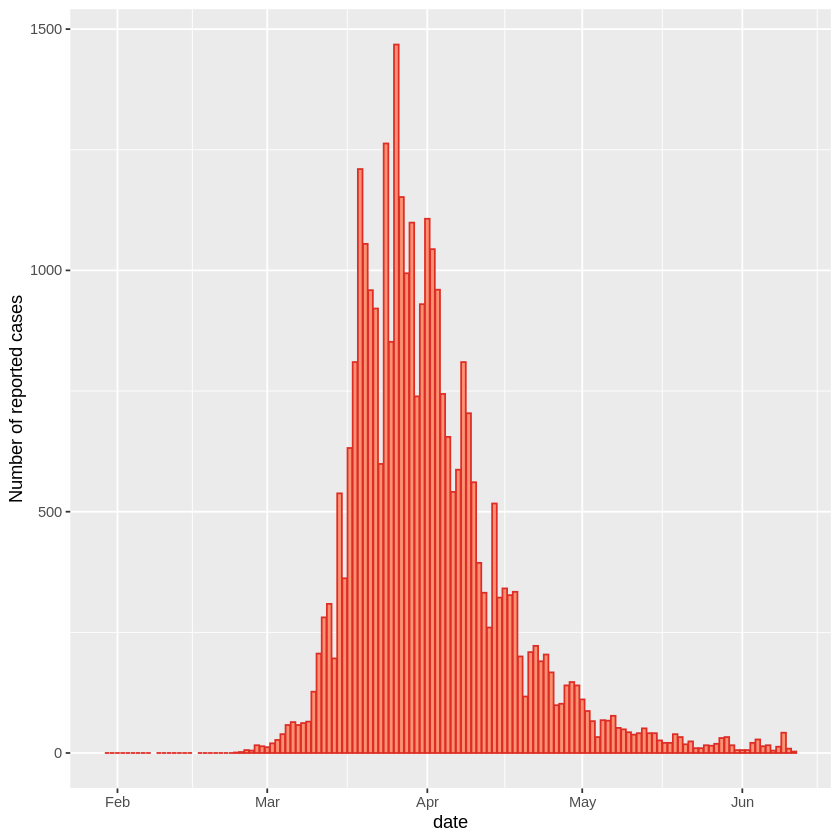

In [8]:
df_swiss %>% 
  ggplot() + 
  geom_bar(mapping = aes(x = date, y = report_dt), fill = c_mid, color = c_dark, stat = "identity") +
  labs(y="Number of reported cases")

### We are going to fit our basic model to the COVID-19 data, but we first need to make a few changes. In the influenza example, the number of students in bed was data on the disease prevalence, that is the number of students infected at time t. In this new setting, we only have access to the number of new cases on each given day, which constitutes incidence data. In a SIR model, the incidence of the disease at time t is the number of people leaving the Susceptible compartment at time t.

In [9]:
# Swiss population
N <- 8.57E6;

#initial conditions
i0 <- 1
s0 <- N - i0
r0 <- 0
y0 = c(S = s0, I = i0, R = r0)

### Improving the model
Our basic model doesn’t match our data. To make it fit, we can think of different improvements to the model to reflect the dynamics of disease:

* Due to the size of the COVID-19 epidemic and to limited testing capacities, there have been massive underreporting of cases. Our model could take this into account.

* Switzerland has put lock-down measures into place, and people have modified their behaviour in reaction to the virus: parameter β
 is not constant over time.

* We could account for the incubation time.

* We could account for the reporting time.

* We could make the initial number of infected people a parameter of the model.

* Given the growing literature on COVID-19, we could add information to our model. This can mean making our priors more informative, or adding different data.

We are going to incorporate several of these improvements into the model. We are going to do it one improvement at a time, to be able to understand where issues are coming from when it happens.

#### Incorporating underreporting
Let’s start with improvement 1, underreporting. We add a single parameter p_reported is the proportion of cases which get reported.

In [24]:
seir_model <- stan_model("./disease_transmission_workflow/stan_models/models_swiss/seir_ode_force.stan")

In [15]:
date_switch <- "2020-03-13" # date of introduction of control measures
tswitch <- df_swiss %>% 
            filter(date < date_switch) %>% 
            nrow() + 1 # convert time to number

In [16]:
tswitch

[1] 42

In [17]:
# Cases
cases <- df_swiss$report_dt

# times
n_days <- length(cases)
t <- seq(1, n_days, by = 1)
t0 = 0
ts <- t

data_seir <- list(n_days = n_days, tswitch = tswitch,t0 = t0, ts = ts, N = N, cases = cases)

In [25]:
fit_seir <- sampling(seir_model, 
                    data_seir, 
                    iter=1000,
                    seed = 0)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.017357 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 173.57 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 954.648 seconds (Warm-up)
Chain 1:                705.577 seconds (Sampling)
Chain 1:                1660.22 

Warning message:
“There were 64 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.39, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”



Divergences:


64 of 2000 iterations ended with a divergence (3.2%).
Try increasing 'adapt_delta' to remove the divergences.




Tree depth:


0 of 2000 iterations saturated the maximum tree depth of 10.




Energy:


E-BFMI indicated no pathological behavior.



,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.912482746,4.017456e-01,0.9110602768,0.380462634,1.251131612,1.965847156,2.552987511,3.70948865,5.142710,1.450770
gamma,0.140049325,2.862505e-02,0.1268486980,0.007650751,0.041918008,0.094541830,0.213156619,0.46024838,19.637193,1.112270
phi,9.007266000,2.105740e-01,1.7168624740,6.171825032,7.768459382,8.864599926,10.110071687,12.81355415,66.475483,1.046888
alpha,0.182587712,1.279609e-01,0.2971251744,0.063093343,0.066332893,0.068287713,0.080603858,1.17532689,5.391682,1.725856
eta,0.432133965,3.136075e-02,0.2300656280,0.019491676,0.284752270,0.436522972,0.616641165,0.81360362,53.818360,1.078697
nu,10.626351150,2.772937e-01,5.9515710896,0.725922425,6.781905645,10.278856323,14.102413701,23.32845090,460.662747,1.011534
xi,0.969091805,1.118194e-02,0.2977559075,0.512972069,0.702497637,0.953044003,1.228025695,1.48192902,709.065890,1.007484
p_rep,0.003616193,5.141977e-05,0.0002475198,0.003207507,0.003451528,0.003584166,0.003743647,0.00421059,23.171784,1.125427


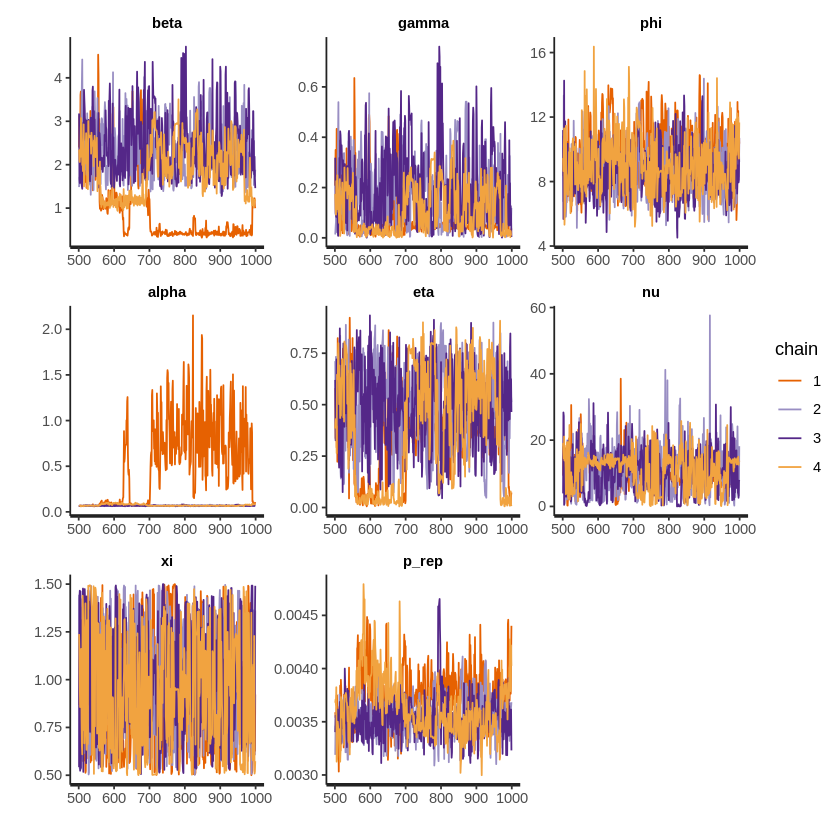

In [26]:
check_hmc_diagnostics(fit_seir)
pars = c("beta", "gamma", "phi", "alpha","eta", 'nu', "xi", "p_rep")
summary(fit_seir, pars=pars)
traceplot(fit_seir, pars=pars)

In [23]:
summary(fit_seir, pars = c("p_rep"))$c_summary

, , chains = chain:1

         stats
parameter        mean           sd        2.5%         25%         50%
    p_rep 0.003532411 0.0001814346 0.003198059 0.003408295 0.003526383
         stats
parameter         75%       97.5%
    p_rep 0.003653206 0.003897994

, , chains = chain:2

         stats
parameter        mean           sd        2.5%         25%         50%
    p_rep 0.005075618 0.0005683613 0.004177359 0.004669509 0.004994827
         stats
parameter         75%       97.5%
    p_rep 0.005414165 0.006291913

, , chains = chain:3

         stats
parameter        mean           sd        2.5%         25%         50%
    p_rep 0.003539321 0.0001890599 0.003173793 0.003413237 0.003537613
         stats
parameter         75%       97.5%
    p_rep 0.003659858 0.003902414

, , chains = chain:4

         stats
parameter        mean          sd        2.5%         25%         50%
    p_rep 0.005015085 0.000563901 0.004067367 0.004650237 0.004984626
         stats
parameter         75%       97.5%
    p_rep 0.005326746 0.006214242

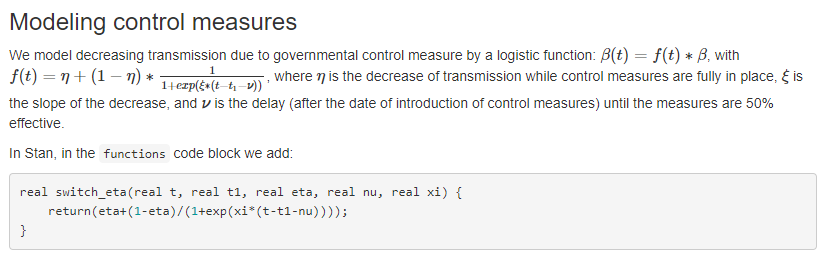

Warning message in par(usr):
“argument 1 does not name a graphical parameter”


Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”


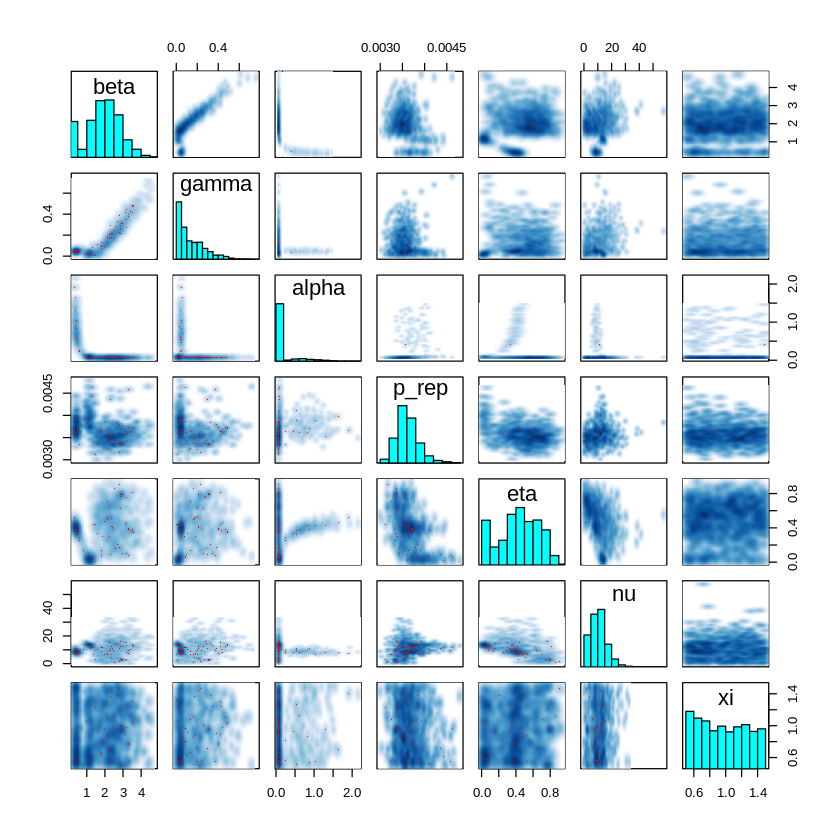

In [30]:
pairs(fit_seir, pars = c("beta", "gamma", "alpha", "p_rep", "eta", "nu", "xi"))

#### Pairs plots are useful to observe correlations between parameters, for instance here between beta and gamma, to analyse more bizarre relationships between parameters, for instance here the relationship between a and nu, and to diagnostic specific inference issues (for instance if all the red points indicating divergences were concentrated in a specific region). We can make several remarks. First, p_reported is still very low. Second, the posterior distributions of eta, nu and xi, the three parameters controlling the effect of governmental measures, are quite uninformative and similar to their prior distributions. Indeed, we can guess that because p_reported is low, transmission can decrease substantially through immunity only, rendering the effect of control measures non identifiable, or at least degenerate.

#### We know that p_reported can’t be so low: this is an information we want to add to the model. This information can take the form of a prior: we could try to refine the prior on p_reported to incorporate more precise domain knowledge. This information can also take the form of additional data: here we can directly fit the data from serological tests into the model!